In [170]:
# Standard Data Science/Analysis Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
import category_encoders as ce

# Inferential Statistical Tests
from scipy.stats import f_oneway, chi2_contingency, ttest_rel
from statsmodels.stats.proportion import proportions_ztest

# Machine Learning Tools, Utilities, and Scoring Metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RepeatedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, mean_squared_error, r2_score, explained_variance_score


# Suite of Machine Learning Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Measure time and memory usage
import time
import psutil
import os

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Display all columns to get a feel for data structure and feature data
pd.set_option('display.max_columns', None)

df = pd.read_csv('data/cleaned_student_success.csv')
df.head()

,marital_status,application_mode,application_order,course,class_time,prev_qual,prev_grade,nationality,mother_qual,father_qual,mother_occ,father_occ,admission_grade,displaced,special_needs,debtor,tuition_current,gender,scholarship,age_enrolled,international,units_cred_1s,units_enr_1s,units_eval_1s,units_app_1s,units_grade_1s,units_no_eval_1s,units_cred_2s,units_enr_2s,units_eval_2s,units_app_2s,units_grade_2s,units_no_eval_2s,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,2
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,2
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,2


In [3]:
TARGET = 'target'
X, y = df.drop(columns=TARGET), df[TARGET]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42)

In [73]:
# Check split worked as intended
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3539, 36), (885, 36), (3539,), (885,))

In [5]:
# Function to Test mutliple different classification models and print
# Accuracy, Spread, Time to Train, and Memory Usage

def test_classification_models(X_train, y_train):
    # Adjustments
    CV = 10
    SCORING = 'accuracy'
    
    
    # Define the models to be tested
    models = {
        "Logistic Regression": LogisticRegression(random_state=42),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": xgb.XGBClassifier(random_state=42),
        "Support Vector Machine": SVC(random_state=42)
    }
    
    # Initialize results dictionary to store metrics for each model
    results = {
        "Model": [],
        "Accuracy (%)": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Perform model evaluation for each model
    for model_name, model in models.items():
        # Measure training time
        start_train_time = time.time()

        # Perform k-fold cross-validation to evaluate the model on the training data
        cv_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=SCORING)

        end_train_time = time.time()
        train_time = end_train_time - start_train_time

        # Measure memory usage (in MB)
        memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        
        # Store the metrics in the results dictionary
        results["Model"].append(model_name)
        results["Accuracy (%)"].append(round(np.mean(cv_scores) * 100, 2))
        results["Spread (std)"].append(round(np.std(cv_scores), 4))
        results["Train Time (s)"].append(round(train_time, 4))
        results["Memory Usage (MB)"].append(round(memory_usage, 0))
        
    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    
    # Print the results
    return results_df

Preliminary results prior to any data preprocessing so that we can understand our baseline score.

In [6]:
# These are preliminary results prior to doing any data preprocessing
baseline_no_preprocessing = test_classification_models(X_train, y_train)
baseline_no_preprocessing.sort_values(['Accuracy (%)'], ascending=False)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
6,XGBoost,78.58,0.0225,3.9123,193.0
5,Gradient Boosting,78.27,0.0186,31.8892,183.0
4,Random Forest,77.37,0.0174,11.2780,178.0
2,Naive Bayes,68.75,0.0196,0.0816,177.0
0,Logistic Regression,68.72,0.0116,0.8013,185.0
3,Decision Tree,68.35,0.0273,0.6351,180.0
7,Support Vector Machine,50.18,0.0064,7.9266,196.0
1,K-Nearest Neighbors,NaN,NaN,0.0408,186.0


I'll start with Scaling. Particularly, we'll investigate how performance changes with Standard Scaling and Min Max Scaling

In [7]:
# Separate true numeric columns where it makes sense to scale
num_cols = [
    'prev_grade',
    'admission_grade',
    'age_enrolled',
    'units_cred_1s',
    'units_enr_1s',
    'units_eval_1s',
    'units_app_1s',
    'units_grade_1s',
    'units_no_eval_1s',
    'units_cred_2s',
    'units_enr_2s',
    'units_eval_2s',
    'units_app_2s',
    'units_grade_2s',
    'units_no_eval_2s',
    'unemployment_rate',
    'inflation_rate',
    'gdp'
]

In [24]:
# Instantiate Standard Scaler and fit to X_train numerical columns
standard_scaler = StandardScaler()
X_train_stan_scaled = standard_scaler.fit_transform(X_train[num_cols])

In [25]:
# Resuls of using Standard Scaler
standard_scaled_baseline = test_classification_models(X_train_stan_scaled, y_train)
standard_scaled_baseline.sort_values(['Accuracy (%)'], ascending=False)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
4,Random Forest,74.94,0.0206,10.5945,228.0
5,Gradient Boosting,74.85,0.0215,25.7996,231.0
0,Logistic Regression,74.17,0.0147,0.5673,237.0
6,XGBoost,74.06,0.0200,4.1127,238.0
7,Support Vector Machine,74.00,0.0144,5.3786,238.0
1,K-Nearest Neighbors,69.88,0.0138,0.0728,237.0
2,Naive Bayes,68.52,0.0268,0.0568,237.0
3,Decision Tree,65.13,0.0271,0.5576,238.0


In [26]:
# Instantiate Standard Scaler and fit to X_train numerical columns
min_max_scaler = MinMaxScaler()
X_train_mm_scaled = min_max_scaler.fit_transform(X_train[num_cols])

In [27]:
# Resuls of using Min Max Scaler
min_max_scaled_baseline = test_classification_models(X_train_mm_scaled, y_train)
min_max_scaled_baseline.sort_values(['Accuracy (%)'], ascending=False)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
4,Random Forest,75.02,0.0200,11.1563,228.0
5,Gradient Boosting,74.85,0.0222,25.1301,231.0
6,XGBoost,74.06,0.0200,2.8311,239.0
7,Support Vector Machine,73.66,0.0181,4.6033,238.0
0,Logistic Regression,73.24,0.0151,0.8533,239.0
1,K-Nearest Neighbors,69.65,0.0226,0.0843,239.0
2,Naive Bayes,68.52,0.0268,0.0633,239.0
3,Decision Tree,65.22,0.0263,0.4946,239.0


Results:
- XGBoost performed best for unscaled data with a accuracy of 78.58%.
- Random Forest performed best on scaled data. It had a slightly higher accuracy (75.02) using the min_max_scaler with slightly less spread.

Further analysis will compare these two models.

In [28]:
# Simpl
# Accuracy, Spread, Time to Train, and Memory Usage

def test_classification_models(X_train, y_train):
    # Adjustments
    CV = 10
    SCORING = 'accuracy'
    
    
    # Define the models to be tested
    models = {
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": xgb.XGBClassifier(random_state=42)
        }
    
    # Initialize results dictionary to store metrics for each model
    results = {
        "Model": [],
        "Accuracy (%)": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Perform model evaluation for each model
    for model_name, model in models.items():
        # Measure training time
        start_train_time = time.time()

        # Perform k-fold cross-validation to evaluate the model on the training data
        cv_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=SCORING)

        end_train_time = time.time()
        train_time = end_train_time - start_train_time

        # Measure memory usage (in MB)
        memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        
        # Store the metrics in the results dictionary
        results["Model"].append(model_name)
        results["Accuracy (%)"].append(round(np.mean(cv_scores) * 100, 2))
        results["Spread (std)"].append(round(np.std(cv_scores), 4))
        results["Train Time (s)"].append(round(train_time, 4))
        results["Memory Usage (MB)"].append(round(memory_usage, 0))
        
    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    
    # Print the results
    return results_df

I'll start with XGBoost

Score to Beat:
* Accuracy (%): 78.58
* Spread: 0.0225
* Time (s): 3.9123
* Memory (MB): 193.0

In [37]:
# Make a copy so that I don't alter the original training data
xgb_X_train = X_train.copy()
xgb_y_train = y_train.copy()

xgb = xgb.XGBClassifier(random_state=42)

In [33]:
"""
Cardinal Features - Utilize target encoding to explore but keep dimensionality low
* course
* nationality
* marital_status
"""

cardinal_features = ['course', 'nationality', 'marital_status']
target_encoder = ce.TargetEncoder(cols=cardinal_features)


In [36]:
xgb_train_encoded = target_encoder.fit_transform(xgb_X_train, xgb_y_train)

In [47]:
def test_xgb_model(X_train, y_train):
    # Adjustments
    CV = 10
    SCORING = 'accuracy'
    
    # Define classifier
    model = xgb
    
    # Initialize results dictionary to store metrics
    results = {
        "Model": [],
        "Accuracy (%)": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Measure training time
    start_train_time = time.time()

    # Perform k-fold cross-validation to evaluate the model on the training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=SCORING)

    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Measure memory usage (in MB)
    memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

    # Store the metrics in the results dictionary
    results["Model"].append("XGBoost")
    results["Accuracy (%)"].append(round(np.mean(cv_scores) * 100, 2))
    results["Spread (std)"].append(round(np.std(cv_scores), 4))
    results["Train Time (s)"].append(round(train_time, 4))
    results["Memory Usage (MB)"].append(round(memory_usage, 0))
    
    # Create a DataFrame to display the results
    xgb_results_df = pd.DataFrame(results)
    
    # Print the results
    return xgb_results_df

In [48]:
test_xgb_model(xgb_train_encoded, xgb_y_train)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost,77.85,0.0159,4.3052,240.0


It seems that Target encoding did not improve the XGB Model. We will continue with the original xgb_X_train data going forward

In [121]:
"""
Ordinal Features - Rank and order label schema and recode as necessary
* Application order - Keep as is
* Mother's qualification - Remap to more logical order
* Father's qualification - Remap to more logical order
"""

ordinal_features = ['mother_qual', 'father_qual']

mother_father_qualification_mapping = {
    35: 0,  # Can't read or write
    36: 1,  # Can read without having a 4th year of schooling
    37: 2,  # Basic education 1st cycle (4th/5th year) or equiv.
    38: 3,  # Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.
    11: 4,  # 7th Year (Old)
    26: 5,  # 7th year of schooling
    30: 6,  # 8th year of schooling
    19: 7,  # Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.
    27: 8,  # 2nd cycle of the general high school course
    29: 9,  # 9th Year of Schooling - Not Completed
    14: 10, # 10th Year of Schooling
    10: 11, # 11th Year of Schooling - Not Completed
    12: 12, # Other - 11th Year of Schooling
    9: 13,  # 12th Year of Schooling - Not Completed
    1: 14,  # Secondary Education - 12th Year of Schooling or Eq. 
    18: 15, # General commerce course
    41: 16, # Specialized higher studies course
    39: 17, # Technological specialization course
    22: 18, # Technical-professional course
    42: 19, # Professional higher technical course
    40: 20, # Higher education - degree (1st cycle)
    43: 21, # Higher Education - Master (2nd cycle)
    2: 22,  # Higher Education - Bachelor's Degree
    3: 23,  # Higher Education - Degree
    4: 24,  # Higher Education - Master's
    5: 25,  # Higher Education - Doctorate
    44: 26, # Higher Education - Doctorate (3rd cycle)
    6: 27,  # Frequency of Higher Education
    34: 28, # Unknown
}

In [126]:
# Map dictionary to data in ordinal columns
xgb_X_train_mapped = xgb_X_train.copy()
for feature in ordinal_features:
    xgb_X_train_mapped[feature] = xgb_X_train_mapped[feature].map(mother_father_qualification_mapping)
    xgb_X_train_mapped[feature] = xgb_X_train_mapped[feature].map(mother_father_qualification_mapping).fillna(28)


In [127]:
test_xgb_model(xgb_X_train_mapped, xgb_y_train)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost,77.65,0.0214,4.4418,249.0


It appears our original model is still slightly outperforming in terms of accuracy so I'll stick with that.

In [64]:
"""
Unrelated Categorical Features - Utilize one hot encoding
* Application mode
* Previous qualification
* Mother's occupation
* Father's occupation
"""

ohe_features = ['application_mode', 'prev_qual', 'mother_occ', 'father_occ']

In [128]:
xgb_X_train_ohe = xgb_X_train.copy()
xgb_X_train_ohe = pd.get_dummies(xgb_X_train_ohe, columns=ohe_features, drop_first=True)

# Check to make sure dummies was applied correctly
list(xgb_X_train_ohe.columns)

['marital_status',
 'application_order',
 'course',
 'class_time',
 'prev_grade',
 'nationality',
 'mother_qual',
 'father_qual',
 'admission_grade',
 'displaced',
 'special_needs',
 'debtor',
 'tuition_current',
 'gender',
 'scholarship',
 'age_enrolled',
 'international',
 'units_cred_1s',
 'units_enr_1s',
 'units_eval_1s',
 'units_app_1s',
 'units_grade_1s',
 'units_no_eval_1s',
 'units_cred_2s',
 'units_enr_2s',
 'units_eval_2s',
 'units_app_2s',
 'units_grade_2s',
 'units_no_eval_2s',
 'unemployment_rate',
 'inflation_rate',
 'gdp',
 'application_mode_2',
 'application_mode_5',
 'application_mode_7',
 'application_mode_10',
 'application_mode_15',
 'application_mode_16',
 'application_mode_17',
 'application_mode_18',
 'application_mode_26',
 'application_mode_27',
 'application_mode_39',
 'application_mode_42',
 'application_mode_43',
 'application_mode_44',
 'application_mode_51',
 'application_mode_53',
 'application_mode_57',
 'prev_qual_2',
 'prev_qual_3',
 'prev_qual_4',
 'p

In [129]:
X_train.shape

(3539, 36)

In [130]:
# This expanded our feature columns to 139 + target
# From 35 + target
xgb_train_ohe.shape

(3539, 140)

In [131]:
test_xgb_model(xgb_X_train_ohe, xgb_y_train)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost,77.73,0.0219,7.8401,252.0


Accuracy has not improved and training time has increased substantailly. I'll stick with the previous model.

In [135]:
# PCA can help reduce dimensionality of our feature space
pca = PCA(0.95)

xgb_X_train_pca = pca.fit_transform(xgb_X_train)
xgb_X_train_pca = pd.DataFrame(xgb_X_train)

In [136]:
test_xgb_model(xgb_X_train_pca, xgb_y_train)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost,78.58,0.0225,3.9159,257.0


In this case it seems to have only increased memory usage so I'll stick with the original data frame.

In [147]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'learning_rate': [0.1, 0.01, 0.001]
    }

In [151]:
xgb_classifier = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=10, refit=True)
grid_search.fit(xgb_X_train, xgb_y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150, 200],
                         'subsample': [0.5, 0.7, 1]})

In [157]:
best_xgb_model = grid_search.best_estimator_
best_xgb_params = grid_search.best_params_
print(best_xgb_params)


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


In [ ]:
xgb_y_train_pred = best_xgb_model.predict(xgb_X_train)

In [159]:
def test_xgb_model(X_train, y_train, grid_search):
    # Adjustments
    SCORING = 'accuracy'
    
    # Get the best model from grid search
    model = grid_search.best_estimator_
    
    # Initialize results dictionary to store metrics
    results = {
        "Model": [],
        "Accuracy (%)": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Measure training time
    start_train_time = time.time()

    # Perform k-fold cross-validation to evaluate the best model on the training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=SCORING)

    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Measure memory usage (in MB)
    memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

    # Store the metrics in the results dictionary
    results["Model"].append("XGBoost (Best Model from Grid Search)")
    results["Accuracy (%)"].append(round(np.mean(cv_scores) * 100, 2))
    results["Spread (std)"].append(round(np.std(cv_scores), 4))
    results["Train Time (s)"].append(round(train_time, 4))
    results["Memory Usage (MB)"].append(round(memory_usage, 0))
    
    # Create a DataFrame to display the results
    xgb_results_df = pd.DataFrame(results)
    
    # Print the results
    return xgb_results_df


In [160]:
test_xgb_model(xgb_X_train, xgb_y_train, grid_search)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost (Best Model from Grid Search),78.95,0.0221,3.8716,413.0


In [161]:
param_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [1, 2, 3],
    'subsample': [1, 1.5, 2],
    'learning_rate': [0.1, 1]
    }

xgb_classifier = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=10, refit=True)
grid_search.fit(xgb_X_train, xgb_y_train)

best_xgb_model = grid_search.best_estimator_
best_xgb_params = grid_search.best_params_
print(best_xgb_params)

test_xgb_model(xgb_X_train, xgb_y_train, grid_search)

In [ ]:
# Class imbalance may be leading to skewed estiamting by our model
# I'll plot a confusion matrix to confirm

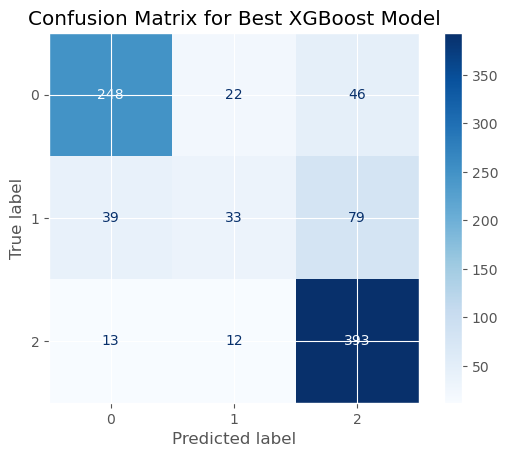

In [177]:
xgb_y_pred = best_xgb_model.predict(xgb_X_train)

xgb_confusion_matrix = confusion_matrix(xgb_y_train, xgb_y_pred)
display_xgb_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_model.classes_)
display_xgb_cm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best XGBoost Model")
plt.show();

We see our model has a lot of false predictions for Graduates (which is the predominant class). We can resample our classes by using SMOTE

In [172]:
xgb_X_train_smote = xgb_X_train.copy()
xgb_y_train_smote = xgb_y_train.copy()

smote = SMOTE(random_state=42)

xgb_X_train_smote, xgb_y_train_smote = smote.fit_resample(xgb_X_train_smote, xgb_y_train_smote)

xgb_X_train_smote.shape, xgb_y_train_smote.shape

((5373, 36), (5373,))

In [174]:
test_xgb_model(xgb_X_train_smote, xgb_y_train_smote, grid_search)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost (Best Model from Grid Search),81.21,0.0538,5.048,317.0


In [181]:
xgb_feature_importances = pd.Series(best_xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
xgb_feature_importances

units_app_2s         0.240960
tuition_current      0.095475
units_enr_1s         0.055954
units_app_1s         0.052675
scholarship          0.048740
units_eval_1s        0.038464
units_eval_2s        0.034061
units_enr_2s         0.032913
units_grade_2s       0.029893
debtor               0.029424
course               0.023838
age_enrolled         0.023251
units_cred_2s        0.020858
inflation_rate       0.019113
mother_occ           0.017734
gender               0.017321
gdp                  0.017140
application_mode     0.015630
units_grade_1s       0.015413
admission_grade      0.013450
units_cred_1s        0.013167
application_order    0.013098
unemployment_rate    0.013096
nationality          0.013055
prev_grade           0.012914
prev_qual            0.011686
units_no_eval_2s     0.011102
units_no_eval_1s     0.011047
father_occ           0.011027
displaced            0.010566
mother_qual          0.010533
father_qual          0.010412
class_time           0.009507
marital_st

In [194]:
threshold = 0.01
important_features = xgb_feature_importances[xgb_feature_importances > threshold].index.tolist()

# Subset the original dataset to include only the important features
xgb_X_train_reduced = xgb_X_train_smote[important_features]
test_xgb_model(xgb_X_train_reduced, xgb_y_train_smote, grid_search)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost (Best Model from Grid Search),81.11,0.0524,4.939,162.0


In [195]:
threshold = 0.05
important_features = xgb_feature_importances[xgb_feature_importances > threshold].index.tolist()

# Subset the original dataset to include only the important features
xgb_X_train_reduced = xgb_X_train_smote[important_features]
test_xgb_model(xgb_X_train_reduced, xgb_y_train_smote, grid_search)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost (Best Model from Grid Search),74.63,0.0336,2.4587,162.0


In [196]:
threshold = 0.025
important_features = xgb_feature_importances[xgb_feature_importances > threshold].index.tolist()

# Subset the original dataset to include only the important features
xgb_X_train_reduced = xgb_X_train_smote[important_features]
test_xgb_model(xgb_X_train_reduced, xgb_y_train_smote, grid_search)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost (Best Model from Grid Search),76.81,0.0408,3.1039,162.0


Final XGBoost Training Result:
* Scaling numerical data had no affect on XGBoost performance
* Target encoding cardinal features had no effect on XGBoost performance
* Reranking ordinal features in a more logical way had no effect on XGBoost performance
* One hot encoding had a negative effect on XGBoost memory usage
* Hyperparameter tuning was completed two times to determine best values in a successively concentrated range. These were determined to be:
    * 'learning_rate': 0.1
    * 'max_depth': 3
    * 'n_estimators': 200
    * 'subsample': 1
* Through SMOTE resampling we were able to boost model performance
* Feature selection using feature importances failed to improve the model
* Model performance boasts 81% accuracy on training data


In [207]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'learning_rate': [0.1, 0.01, 0.001]
    }

In [208]:
xgb_classifier = xgb.XGBClassifier(random_state=42)

grid_search_smote = GridSearchCV(xgb_classifier, param_grid, cv=10, refit=True)
grid_search_smote.fit(xgb_X_train_smote, xgb_y_train_smote)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150, 200],
                         'subsample': [0.5, 0.7, 1]})

In [209]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}

In [210]:
grid_search_smote.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}

In [211]:
best_xgb_model = grid_search_smote.best_estimator_
best_xgb_params = grid_search_smote.best_params_
print(best_xgb_params)


{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}


In [212]:
xgb_y_train_pred = best_xgb_model.predict(xgb_X_train_smote)

In [214]:
def test_xgb_model(X_train, y_train, grid_search):
    # Adjustments
    SCORING = 'accuracy'
    
    # Get the best model from grid search
    model = grid_search.best_estimator_
    
    # Initialize results dictionary to store metrics
    results = {
        "Model": [],
        "Accuracy (%)": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Measure training time
    start_train_time = time.time()

    # Perform k-fold cross-validation to evaluate the best model on the training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=SCORING)

    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Measure memory usage (in MB)
    memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

    # Store the metrics in the results dictionary
    results["Model"].append("XGBoost (Best Model from Grid Search)")
    results["Accuracy (%)"].append(round(np.mean(cv_scores) * 100, 2))
    results["Spread (std)"].append(round(np.std(cv_scores), 4))
    results["Train Time (s)"].append(round(train_time, 4))
    results["Memory Usage (MB)"].append(round(memory_usage, 0))
    
    # Create a DataFrame to display the results
    xgb_results_df = pd.DataFrame(results)
    
    # Print the results
    return xgb_results_df


In [215]:
test_xgb_model(xgb_X_train_smote, xgb_y_train_smote, grid_search_smote)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost (Best Model from Grid Search),85.71,0.0565,13.3446,307.0


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'learning_rate': [0.1, 0.01, 0.001]
    }

In [216]:
print(best_xgb_params)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}


In [218]:
param_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [6, 7, 8],
    'subsample': [0.6, 0.7, 0.8],
    'learning_rate': [0.1, 1]
    }

xgb_classifier = xgb.XGBClassifier(random_state=42)

grid_search_smote = GridSearchCV(xgb_classifier, param_grid, cv=10, refit=True)
grid_search_smote.fit(xgb_X_train_smote, xgb_y_train_smote)

best_xgb_model = grid_search.best_estimator_
best_xgb_params = grid_search.best_params_
print(best_xgb_params)

test_xgb_model(xgb_X_train_smote, xgb_y_train_smote, grid_search_smote)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost (Best Model from Grid Search),86.59,0.0577,39.0058,303.0


In [219]:
xgb_y_pred_final = best_xgb_model.predict(X_test)
xgb_test_accuracy = accuracy_score(y_test, xgb_y_pred_final)
print(f'XGB Test Accuracy: {xgb_test_accuracy * 100:.2f}%')

test_xgb_model(X_test, y_test, grid_search_smote)

XGB Test Accuracy: 77.06%


In [220]:
test_xgb_model(X_test, y_test, grid_search_smote)

,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost (Best Model from Grid Search),74.01,0.0271,8.8226,308.0


In [206]:
test_xgb_model(xgb_X_train_smote, xgb_y_train_smote, grid_search)



,Model,Accuracy (%),Spread (std),Train Time (s),Memory Usage (MB)
0,XGBoost (Best Model from Grid Search),81.21,0.0538,5.2419,173.0


In [199]:
xgb_y_pred_final = best_xgb_model.predict(X_test)
xgb_test_accuracy = accuracy_score(y_test, xgb_y_pred_final)
print(f'XGB Test Accuracy: {xgb_test_accuracy * 100:.2f}%')

XGB Test Accuracy: 77.06%


In [205]:
smote = SMOTE(random_state=42)

# Initialize XGBClassifier with the best hyperparameters
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    subsample=1,
    random_state=42
)

# Create the pipeline with SMOTE and the pre-configured XGBoost model
pipeline = Pipeline([
    ('smote', smote),  # Apply SMOTE resampling
    ('xgb', xgb_model) # Pre-configured XGBoost model
])

# Fit the pipeline to the training data (resampling applies only to training)
pipeline.fit(xgb_X_train_smote, xgb_y_train_smote)

# Make predictions on the test set (SMOTE is NOT applied to the test set)
xgb_y_pred_final = pipeline.predict(X_test)

# Calculate accuracy on the test set
xgb_test_accuracy = accuracy_score(y_test, xgb_y_pred_final)
print(f'XGB Test Accuracy: {xgb_test_accuracy * 100:.2f}%')


XGB Test Accuracy: 75.03%


In [11]:
print(y_train.value_counts())

target
2    1791
0    1105
1     643
Name: count, dtype: int64


Logistic Regression shows promise with an average accuracy of 74.15%. Will look into model improvement

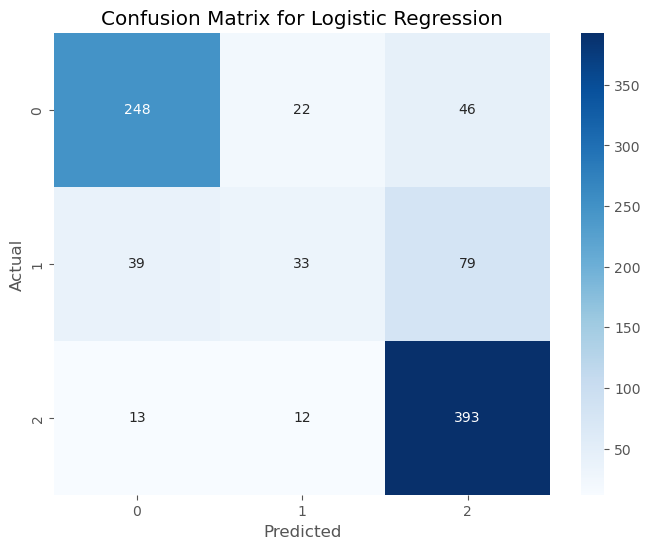

Confusion Matrix:
 [[248  22  46]
 [ 39  33  79]
 [ 13  12 393]]


In [12]:
# Fit the Logistic Regression model
model = xgb()
model.fit(xgb_train, y_train)

# Predict the target values for X_test
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optionally, print the confusion matrix as text
print("Confusion Matrix:\n", cm)

Medium: https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d